In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import os

In [56]:
# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [57]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
testDF = df_encoded
print(df_encoded['diabetes'].value_counts())

0    91500
1     8500
Name: diabetes, dtype: int64


In [58]:
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## Testing the MLP Model

In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# Define input dimensions and load the model
input_dim = x_scaled.shape[1]
model = MLP(input_dim).to(device)

# Load the saved model
model_file = './models/mlp_model_resampled_0.1.pth'
if os.path.exists(model_file):
    model.load_state_dict(torch.load(model_file))
    print("Model loaded successfully.")
else:
    print("Model file does not exist.")
    raise FileNotFoundError("Model file not found.")

# Convert x_scaled to a torch tensor
x_scaled_tensor = torch.tensor(x_scaled.values, dtype=torch.float32).to(device)

# Make predictions on the entire dataset
model.eval()
with torch.no_grad():
    y_pred = model(x_scaled_tensor).cpu().numpy()

# Calculate the Mean Squared Error (MSE) on the entire dataset
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Entire Dataset: {rmse}')

# Convert y_pred to binary predictions
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Ensure y is a numpy array and reshape if necessary
y_array = y.values if hasattr(y, 'values') else y
if y_array.ndim > 1:
    y_array = y_array.reshape(-1)

# Ensure y_pred_binary is a 1-dimensional array
if y_pred_binary.ndim > 1:
    y_pred_binary = y_pred_binary.reshape(-1)

# Compare y_pred_binary with y
correct_predictions = np.sum(y_pred_binary == y_array)
wrong_predictions = np.sum(y_pred_binary != y_array)

# Track indices of wrong predictions
wrong_prediction_indices = np.where(y_pred_binary != y_array)[0]

# Calculate additional metrics
true_positives = np.sum((y_pred_binary == 1) & (y_array == 1))
true_negatives = np.sum((y_pred_binary == 0) & (y_array == 0))
false_positives = np.sum((y_pred_binary == 1) & (y_array == 0))
false_negatives = np.sum((y_pred_binary == 0) & (y_array == 1))

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Wrong Predictions: {wrong_predictions}")
print(f"Number of True Positives (1 predicted as 1): {true_positives}")
print(f"Number of True Negatives (0 predicted as 0): {true_negatives}")
print(f"Number of False Positives (0 predicted as 1): {false_positives}")
print(f"Number of False Negatives (1 predicted as 0): {false_negatives}")

# Evaluate the model on the test set
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = nn.MSELoss()(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE) on the test set
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')

Using device: cuda
Model loaded successfully.
Root Mean Squared Error on Entire Dataset: 0.15907830453366031
Number of Correct Predictions: 96857
Number of Wrong Predictions: 3143
Number of True Positives (1 predicted as 1): 5457
Number of True Negatives (0 predicted as 0): 91400
Number of False Positives (0 predicted as 1): 100
Number of False Negatives (1 predicted as 0): 3043


C:\Users\ROG\AppData\Local\Temp/ipykernel_21640/422902904.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Test Loss: 0.0244
Test MAE: 0.0512


In [60]:
print("Indices of Wrong Predictions:", wrong_prediction_indices)

Indices of Wrong Predictions: [    1    44   126 ... 99985 99987 99997]


## Testing the autoencoder model

Using device: cuda
Mean Squared Error (MSE): 0.0021021463193453918
Mean Absolute Error (MAE): 0.022595331407216382
Reconstruction Error Percentage: 0.21%
Number of samples with errors over 1%: 764
Number of samples with errors over 1.5%: 272
Number of samples with errors over 2%: 120
Number of samples with errors over 2.5%: 61
Number of samples with errors over 3%: 41
Number of samples with errors over 3.5%: 33
Number of samples with errors over 4%: 29
Number of samples with errors over 5%: 20


C:\Users\ROG\AppData\Local\Temp/ipykernel_21640/2531132214.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Us

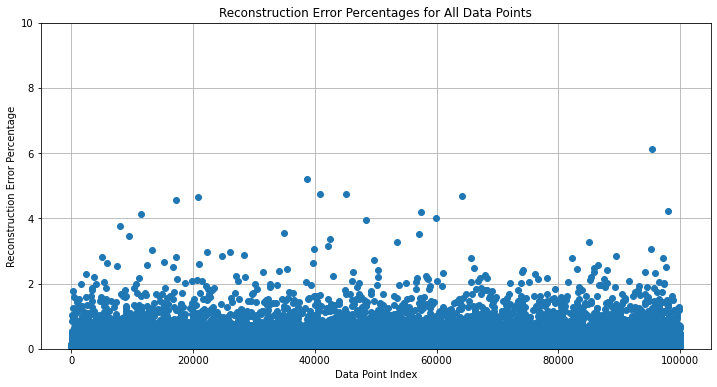

In [61]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the Decoder model with increased complexity
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define input dimensions and encoding dimensions
input_dim = x_scaled.shape[1]  # Set this to the number of features in your data
encoding_dim = 13

# Model file paths
encoder_model_file = './models/encoder.pth'
decoder_model_file = './models/decoder.pth'

# Load the encoder and decoder models
encoder = Encoder(input_dim, encoding_dim).to(device)
decoder = Decoder(encoding_dim, input_dim).to(device)

encoder.load_state_dict(torch.load(encoder_model_file))
decoder.load_state_dict(torch.load(decoder_model_file))

encoder.eval()
decoder.eval()

# Combine Encoder and Decoder to form the Autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

# Convert x_scaled to a torch tensor
x_scaled = x_scaled.values 
x_scaled_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

# Reconstruct x_scaled using the autoencoder
with torch.no_grad():
    x_reconstructed = autoencoder(x_scaled_tensor).cpu().numpy()

# Calculate Mean Squared Error (MSE)
mse = np.mean((x_scaled - x_reconstructed) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(x_scaled - x_reconstructed))
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Reconstruction Error Percentage
reconstruction_error = np.mean(np.square(x_scaled - x_reconstructed), axis=1)
reconstruction_error_percentage = np.mean(reconstruction_error) * 100
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage:.2f}%')

# Define thresholds
thresholds = [1, 1.5, 2, 2.5, 3, 3.5, 4, 5]

# Store the number of samples with errors exceeding thresholds
error_counts = {threshold: np.sum(reconstruction_error * 100 > threshold) for threshold in thresholds}

# Print the number of samples with errors exceeding each threshold
for threshold, count in error_counts.items():
    print(f'Number of samples with errors over {threshold}%: {count}')

# Plot the reconstruction error percentages for all data points
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_error * 100, marker='o', linestyle='none')
plt.title('Reconstruction Error Percentages for All Data Points')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error Percentage')
plt.ylim(0, 10)  # Scale the y-axis from 0 to 10
plt.grid(True)
plt.show()

In [62]:
# Find indices with over 2.5% reconstruction error
high_error_indices = np.where(reconstruction_error * 100 > 0.21)[0]

# Find the overlap between wrong_prediction_indices and high_error_indices
overlap_indices = np.intersect1d(wrong_prediction_indices, high_error_indices)

print(f"Number of overlapping indices: {len(overlap_indices)}")
print("Overlapping indices:", overlap_indices)

Number of overlapping indices: 595
Overlapping indices: [  235   400   614   658   712   850  1105  1113  1163  1253  1578  1666
  1703  2130  2307  2417  2803  3140  3145  3436  3643  3729  4018  4100
  4190  4858  5020  5031  5465  5484  5618  5754  5986  6269  6284  6321
  6579  6944  7105  7221  7767  7836  7904  8026  8125  8318  8363  8485
  8719  8720  8726  8730  8772  9081  9093  9454  9642 10127 10373 10957
 11097 11182 11243 11418 11520 11556 11816 11899 12007 12398 12463 12607
 12745 13032 13287 13459 13899 14248 14538 15195 15311 15618 15744 15751
 16034 16127 16298 16389 16599 17047 17080 17085 17232 17539 17940 17958
 18494 18557 18642 18862 18870 18928 19072 19119 19221 19246 19644 19819
 19893 20579 20744 20764 20773 20829 20923 21243 21463 21493 21571 21957
 21981 22230 22268 22378 22434 22494 22584 22763 23080 23330 23420 23532
 23549 23984 24175 24221 24569 24714 25025 25135 25760 25799 25863 26182
 26198 26339 26582 26655 27147 27947 28348 28373 28573 28738 28745 2

Reconstruction Errors for Wrong Predictions: [0.00134754 0.00125509 0.00050143 ... 0.00068941 0.00105297 0.00651119]
Mean Reconstruction Error for Wrong Predictions: 0.0015411484500427641
Standard Deviation of Reconstruction Error for Wrong Predictions: 0.002267851715088761


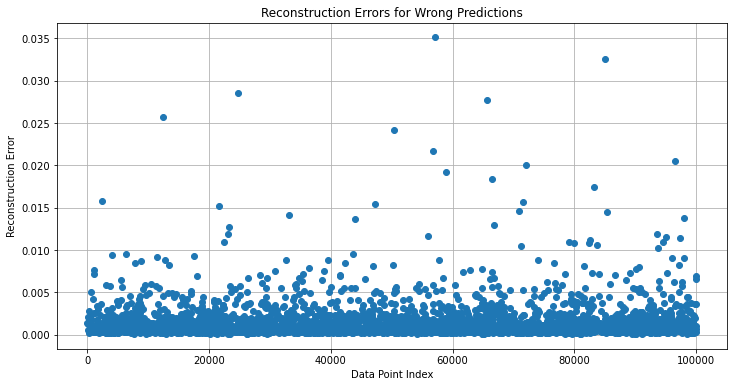

In [63]:
# Filter the reconstruction errors for the wrong prediction indices
wrong_prediction_reconstruction_errors = reconstruction_error[wrong_prediction_indices]

# Print the reconstruction errors for the wrong prediction indices
print("Reconstruction Errors for Wrong Predictions:", wrong_prediction_reconstruction_errors)

# Optionally, you can calculate some statistics like mean and standard deviation
mean_error = np.mean(wrong_prediction_reconstruction_errors)
std_error = np.std(wrong_prediction_reconstruction_errors)

print(f"Mean Reconstruction Error for Wrong Predictions: {mean_error}")
print(f"Standard Deviation of Reconstruction Error for Wrong Predictions: {std_error}")

# Plot the reconstruction errors for the wrong prediction indices
plt.figure(figsize=(12, 6))
plt.plot(wrong_prediction_indices, wrong_prediction_reconstruction_errors, marker='o', linestyle='none')
plt.title('Reconstruction Errors for Wrong Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()